# People Analytics BRI Data Challenge

# Recap


## 26 December 2020

1. XGBOOST UNTUNED BAGGED with data FEATURE SELECTION set to true and random under sampling perform highest
2. Might try use random forest or decision tree with the same preprocessing
3. try upload catboost bagged untuned answer (done, lower than xgboost)

## 28 December 2020

1. Oversampling seems to yield worser performance.
2. try xgboost tuned

In [1]:
# Importing Libraries and data to Jupyter Notebook.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier 
from sklearn.preprocessing import MinMaxScaler
from pycaret import classification
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import VotingClassifier

In [2]:
# Peek at the data
df = pd.read_csv('./train.csv')
print('Shape of the data: {0[0]} rows with {0[1]} columns.'.format(df.shape))
df.head(4)

Shape of the data: 22005 rows with 30 columns.


,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),number_of_dependences,number_of_dependences (male),number_of_dependences (female),Education_level,GPA,year_graduated,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,3,1,2,level_4,2.32,1987,30.0,30,9,7,0,8,0,0,68.85,72.53,0.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,3,2,1,level_4,3.25,2001,15.0,16,7,7,9,3,0,0,94.81,101.13,3.0,achiev_50%-100%,achiev_50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,1,0,1,level_5,3.23,2007,15.0,15,9,9,0,6,0,0,72.82,71.30,0.0,achiev_100%-150%,achiev_< 50%,not_reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,0,0,0,level_3,0.00,2006,8.0,8,5,5,0,3,0,0,86.89,90.09,2.0,achiev_50%-100%,achiev_50%-100%,not_reached


# Data Preprocessing

In [3]:
# Find features with missing values and understand the missing values ratio.
def check_na(df):
    nas =  pd.DataFrame([(x, df[x].isnull().sum()*100/len(df)) for x in df]).rename(columns= {0: 'Feature', 1:'Missing Values Ratio'})
    return nas[nas['Missing Values Ratio'] != 0]

In [4]:
check_na(df)

,Feature,Missing Values Ratio
5,Employee_type,0.054533
13,Education_level,16.396274
14,GPA,15.919109
15,year_graduated,15.919109
16,job_duration_as_permanent_worker,9.338787
24,Avg_achievement_%,28.579868
25,Last_achievement_%,28.638946
26,Achievement_above_100%_during3quartal,28.638946
27,achievement_target_1,30.570325
28,achievement_target_2,30.570325


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22005 entries, 0 to 22004
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              22005 non-null  object 
 1   job_duration_in_current_job_level      22005 non-null  float64
 2   person_level                           22005 non-null  object 
 3   job_duration_in_current_person_level   22005 non-null  float64
 4   job_duration_in_current_branch         22005 non-null  float64
 5   Employee_type                          21993 non-null  object 
 6   Employee_status                        22005 non-null  object 
 7   gender                                 22005 non-null  object 
 8   age                                    22005 non-null  int64  
 9   marital_status_maried(Y/N)             22005 non-null  object 
 10  number_of_dependences                  22005 non-null  int64  
 11  nu

In [6]:
df.describe()

,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,age,number_of_dependences,number_of_dependences (male),number_of_dependences (female),GPA,job_duration_as_permanent_worker,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal
count,22005.000000,22005.000000,22005.000000,22005.000000,22005.000000,22005.000000,22005.000000,18502.000000,19950.000000,22005.000000,22005.000000,22005.000000,22005.000000,22005.000000,22005.000000,22005.000000,15716.000000,15703.000000,15703.000000
mean,1.733252,1.555544,1.088203,1987.398682,0.746239,0.379232,0.366917,2.994603,4.872481,4.546876,2.889571,2.832265,0.818723,2.794138,0.898069,0.121245,66.344676,71.420847,0.682991
std,1.422136,0.954620,0.839882,4.274737,0.840026,0.606961,0.597422,11.699025,4.500514,4.519389,2.193424,1.751125,2.250188,2.822423,2.848540,0.326419,23.253675,24.095520,1.107861
min,0.000000,0.000000,0.000000,1963.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.260000,0.000000
25%,1.170000,1.080000,0.500000,1986.000000,0.000000,0.000000,0.000000,2.810000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,51.675000,55.935000,0.000000
50%,1.580000,1.500000,0.830000,1988.000000,1.000000,0.000000,0.000000,3.090000,4.000000,4.000000,2.000000,2.000000,0.000000,3.000000,0.000000,0.000000,66.310833,71.410000,0.000000
75%,1.920000,1.830000,1.500000,1990.000000,1.000000,1.000000,1.000000,3.300000,6.000000,5.000000,3.000000,3.000000,0.000000,5.000000,1.000000,0.000000,81.930833,88.350000,1.000000
max,8.750000,8.000000,7.500000,2017.000000,7.000000,4.000000,4.000000,381.000000,34.000000,35.000000,22.000000,15.000000,54.000000,41.000000,132.000000,1.000000,129.010000,130.000000,3.000000


### Achievement Target Data Cleaning

In [7]:
def clean_achievement_target(df):
    target = ['achievement_target_1', 'achievement_target_2', 'achievement_target_3']
    for name in target:
        df[name] = df[name].map({
            'achiev_< 50%' : 'achieve_less_than_50%',
            'Pencapaian < 50%' : 'achieve_less_than_50%%',
            'achiev_50%-100%' : 'achieve_between_50%_and_100%',
            'Pencapaian 50%-100%' : 'achieve_between_50%_and_100%',
            'achiev_100%-150%' : 'achieve_between_100%_and_150%',
            'Pencapaian 100%-150%' : 'achieve_between_100%_and_150%',
            'achiev_> 1.5' : 'achieve_more_than_150%',
            'Pencapaian > 1.5' : 'achieve_more_than_150%',
            'Tidak diberikan target' : 'no_target'
        }).fillna('no_target')
    return df

In [8]:
df = clean_achievement_target(df)

### Achievement Values Data Cleaning

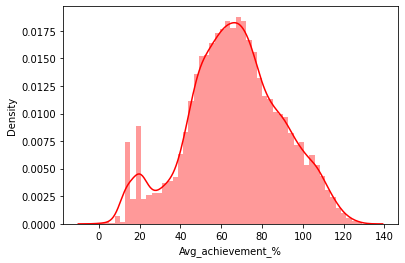

In [9]:
sns.distplot(df['Avg_achievement_%'], norm_hist=True, kde=True, hist = True, color = 'red');
df['Avg_achievement_%'].fillna(df['Avg_achievement_%'].mean(skipna = True), inplace = True);

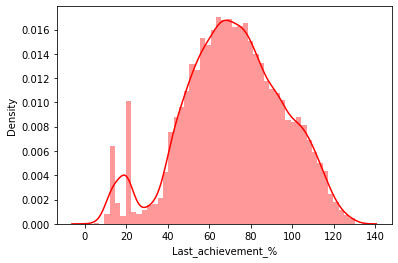

In [10]:
sns.distplot(df['Last_achievement_%'], norm_hist=True, kde=True, hist = True, color = 'red');
df['Last_achievement_%'].fillna(df['Last_achievement_%'].mean(skipna = True), inplace = True)

In [11]:
df['Achievement_above_100%_during3quartal'].fillna('no_info', inplace = True)

### Academics Data Cleaning

In [11]:
# Year Graduation
def fix_year(df, plot = False):
    year_to_change = [] 
    
    for i in range(0, len(df)):
        if (df.loc[i, 'year_graduated'] == '0'):
                year_to_change.append(i)
        try:
            int(df.loc[i, 'year_graduated'])
        except:
            year_to_change.append(i)

    val_year_grad = df['year_graduated'].drop(year_to_change).median()
    df.loc[year_to_change, 'year_graduated'] = val_year_grad
    if plot:
        sns.distplot(df['year_graduated'])
        plt.show()
    df['year_graduated'].fillna(val_year_grad, inplace = True)
    df['year_graduated'] = [int(x) for x in df['year_graduated']]

In [12]:
def fix_gpa(df, plot = False):
    mean_gpa = df.loc[(df['GPA'] > 0) & (df['GPA'] <= 4), 'GPA'].mean()
    df.loc[(df['GPA'] > 4) | (df['GPA'] == 0), 'GPA'] = mean_gpa
    if plot:
        sns.distplot(df['GPA'].sort_values().values);
        plt.show()
    df['GPA'].fillna(mean_gpa, inplace = True)

In [13]:
df['Education_level'].fillna('Other', inplace = True)

### Other Cleaning Process

In [14]:
def convert_job_person_level(df):
    cols = ['job_level', 'person_level']
    
    df[cols[0]] = [int(x[-1:]) for x in df[cols[0]]]
    df[cols[1]] = [int(x[-1:]) for x in df[cols[1]]]

In [15]:
# plt.subplot(1, 2, 1)
fix_year(df)
# plt.subplot(1, 2, 2)
fix_gpa(df)
# plt.tight_layout()
convert_job_person_level(df)

In [16]:
med_job_dur = df['job_duration_as_permanent_worker'].mean(skipna = True)
df['job_duration_as_permanent_worker'].fillna(med_job_dur, inplace = True)

In [17]:
check_na(df)

,Feature,Missing Values Ratio
5,Employee_type,0.054533
26,Achievement_above_100%_during3quartal,28.638946


In [18]:
df.dropna(inplace = True, axis = 0)

# Exploratory Data Analysis

In [19]:
df.columns

Index(['job_level', 'job_duration_in_current_job_level', 'person_level',
       'job_duration_in_current_person_level',
       'job_duration_in_current_branch', 'Employee_type', 'Employee_status',
       'gender', 'age', 'marital_status_maried(Y/N)', 'number_of_dependences',
       'number_of_dependences (male)', 'number_of_dependences (female)',
       'Education_level', 'GPA', 'year_graduated',
       'job_duration_as_permanent_worker', 'job_duration_from_training',
       'branch_rotation', 'job_rotation', 'assign_of_otherposition',
       'annual leave', 'sick_leaves', 'Best Performance', 'Avg_achievement_%',
       'Last_achievement_%', 'Achievement_above_100%_during3quartal',
       'achievement_target_1', 'achievement_target_2', 'achievement_target_3'],
      dtype='object')

In [ ]:
numeric_features =  df.drop('Best Performance', axis = 1).dtypes[df.dtypes != 'object'].index
corrmat = df[numeric_features].corr()
high_corr_features = corrmat[abs(corrmat) > 0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(corrmat,annot=False,cmap="RdYlGn")

In [ ]:
df.groupby('Best Performance')['Achievement_above_100%_during3quartal'].value_counts().plot(kind = 'bar');

In [ ]:
df.groupby('Best Performance')[['job_duration_as_permanent_worker', 'job_duration_from_training',
    'branch_rotation', 'job_rotation']].plot(kind = 'density',figsize = (8, 8))

In [ ]:
# Age and Best Performance Data
df.groupby('Best Performance')[['age']].plot(kind = 'box');

In [ ]:
# Best Performance based on gender
df.groupby('gender').agg(sum)['Best Performance'].plot(kind = 'bar');

In [ ]:
# Job rotation based on best performance results
df.groupby('Best Performance')['job_rotation'].plot(kind = 'density', legend = True);

In [ ]:
df.groupby('Best Performance')['assign_of_otherposition'].plot(kind = 'density', legend = True);

# Saving Cleaned Data

In [22]:
def transform_data(df):
    
    num_feat_final = df.drop('Best Performance', axis  = 1, errors = 'ignore').dtypes[df.dtypes != 'object'].index
    
    categorical = df.drop(list(num_feat_final), axis = 1, errors='ignore').drop('Best Performance' 
                                                                                , errors = 'ignore', axis = 1).columns
    
    final_features = df.drop('Best Performance', axis = 1, errors = 'ignore').columns
    
    df = pd.get_dummies(df, columns= list(categorical))
    
    return df

In [ ]:
# keep = ['job_rotation', 'job_level', 'person_level', 'marital_status_maried(Y/N)', 'age', 'gender', 'GPA', 
#            'job_duration_as_permanent_worker', 'job_duration_from_training', 'Last_achievement_%', 'achievement_target_1', 'achievement_target_2',
#        'achievement_target_3', 'Best Performance', 'Employee_type', 'year_graduated']

# df_ = df_[keep]

In [23]:
# Make data with and without dummies columns
# Save The cleaned data for further processing

# Without Dummies
df_wo_dummies = df.copy().dropna().to_csv('../People Analytics BRI/Cleaned_data_train_wo_dummy.csv')

# With Dummies
df = transform_data(df)
df.dropna().to_csv('../People Analytics BRI/Cleaned_data_train.csv')

# Modelling Process

### Dealing With Imbalanced Classes

In [24]:
# Loading Data with dummies
df = pd.read_csv('../People Analytics BRI/Cleaned_data_train.csv')

df = df.sample(n = int(len(df)*0.9))
df.drop(df.columns[0], axis = 1, inplace = True)

val = pd.read_csv('../People Analytics BRI/Cleaned_data_train.csv').drop(df.index).rename(columns = {'Unnamed: 0':''})
val.drop(val.columns[0], axis = 1, inplace = True)

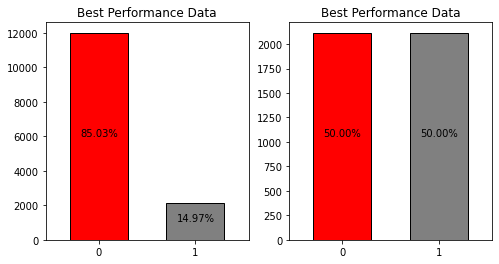

In [25]:
# Classes Distribution Plot
plt.subplot(1, 2, 1)

plt.title('Best Performance Data')
plt.xticks(rotation=0)

ax = df['Best Performance'].value_counts().plot(kind = 'bar', figsize=(8,4), width=0.6, color= ['red', 'gray'], edgecolor='black');

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/len(df):.2%}', (x + width/2, y + height*.5), ha='center')

plt.xticks(rotation = 0)
    
# Makind Data Balanced
plt.subplot(1, 2, 2)

# Combining Over and Under Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# over = RandomOverSampler(sampling_strategy = 'minority')
under = RandomUnderSampler()

# X_resampled, y_resampled = over.fit_sample(df.drop('Best Performance', axis = 1), df['Best Performance'])
X_resampled, y_resampled = under.fit_sample(df.drop('Best Performance', axis = 1), df['Best Performance'])

df_resampled = X_resampled.copy()
df_resampled['Best Performance'] = y_resampled

ax = df_resampled['Best Performance'].value_counts().plot(kind = 'bar', figsize=(8,4), width=0.6, 
                                                 color= ['gray', 'red'], edgecolor='black');
plt.title('Best Performance Data')
plt.xticks(rotation=0)
plt.gca().invert_xaxis()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/len(df_resampled):.2%}', (x + width/2, y + height*.5), ha='center')

### Splitting The Data into Train and Test Set

In [26]:
X = df_resampled.drop('Best Performance', axis = 1)
Y = df_resampled['Best Performance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

# scaler = MinMaxScaler().fit(X_train)
# X_train = pd.DataFrame(data = scaler.transform(X_train), columns = X.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [27]:
def report(y_test, y_pred, model_name, model):
    
    print('The ROC AUC Score for', model_name, 'is: {:.2f}'.format(roc_auc_score(y_test, y_pred)))
    print('\nConfusion Matrix: ')
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred, labels = [0, 1]), columns = ['Predict 0', 'Predict 1'], index = ['Class 0', 'Class 1'])
    print(conf_mat)

    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
    print('\nMetrics Reports')
    print(classification_report(y_test, y_pred))
    
    try:
        feature_impr = pd.DataFrame(data = model.feature_importances_*100, 
                     index=df.drop('Best Performance', axis = 1).columns.to_list()).rename(columns = 
                                                                                           {0: 'Feature Importance'}).sort_values(by=['Feature Importance'], ascending=False)

        ax = feature_impr.iloc[0:11, :].plot(kind = 'barh', figsize=(6,6), xlim = [0, feature_impr.iloc[0:11, 0].max() + 5], legend = False)
        plt.title('Top 10 Features for the ' + model_name  + ' Model')

        for i, v in enumerate(feature_impr.iloc[0:11, 0]):
            ax.text(v + 0.25, i + .25, str(round(v, 2)), color='black', fontweight='bold')

        plt.gca().invert_yaxis()
        plt.show()
    except:
        print('')

### Plotting Trees

In [28]:
from sklearn import tree
tree_ = tree.DecisionTreeClassifier(random_state=0, 
                                    min_impurity_split = 0.2)
tree_ = tree_.fit(X_train[['year_graduated']], y_train)
# plt.figure(figsize = (16, 16))
# tree.plot_tree(tree_, feature_names=['job_rotation', 'age', 'Avg_achievement_%'], 
#                impurity = True,  class_names = ['0', '1'])
# plt.show()

In [ ]:
report(tree_.predict(val.drop('Best Performance', axis = 1)[['year_graduated']]),val['Best Performance'], 'DTree', tree)

### XGB Model

In [ ]:
# n_estimators = 1000, random_state = 0,  
#                           use_label_encoder=False, eval_metric = 'logloss',
#                          learning_rate = 0.0001, n_jobs = -1

The ROC AUC Score for Gradient Boosting is: 0.52

Confusion Matrix: 
         Predict 0  Predict 1
Class 0        350        274
Class 1        336        310

Metrics Reports
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       624
           1       0.53      0.48      0.50       646

    accuracy                           0.52      1270
   macro avg       0.52      0.52      0.52      1270
weighted avg       0.52      0.52      0.52      1270



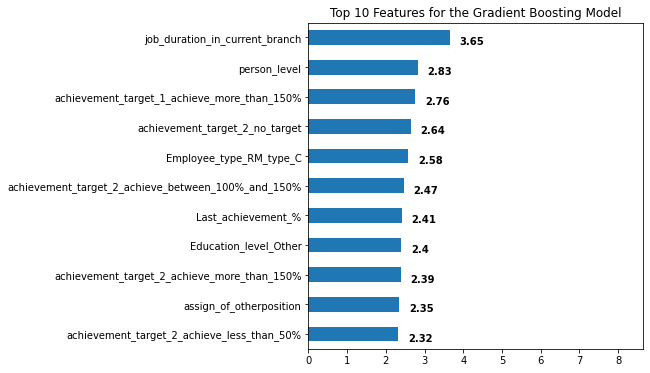

In [29]:
fit_xgb = XGBRFClassifier(n_estimators = 350, random_state = 0,  
                          use_label_encoder=False, eval_metric = 'aucpr',
                          learning_rate = 0.005, n_jobs = -1, max_depth = 18, gamma = 0.7
).fit(X_train, y_train)

y_pred_xgb = fit_xgb.predict(X_test)
report(y_test, y_pred_xgb, 'Gradient Boosting', fit_xgb)

In [30]:
report(val['Best Performance'], fit_xgb.predict(val.drop('Best Performance', axis = 1)), 'Gradient Boosting', '')

The ROC AUC Score for Gradient Boosting is: 0.55

Confusion Matrix: 
         Predict 0  Predict 1
Class 0        776        568
Class 1        107        120

Metrics Reports
              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1344
           1       0.17      0.53      0.26       227

    accuracy                           0.57      1571
   macro avg       0.53      0.55      0.48      1571
weighted avg       0.78      0.57      0.63      1571




In [ ]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores
evaluate_model(fit_xgb, X, Y)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# parameter_space = {
# "learning_rate"     : [0.05, 0.10, 0.15, 0.20, 0.25],
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
#  "min_child_weight" : [ 1, 3, 5, 7],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7]
# }   

# clf = GridSearchCV(fit_xgb, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train)

### Random Forest Model

Random Forest Need Parameter Tuning !!

In [ ]:
fit_rf = rfc(random_state=1, n_jobs=-1, n_estimators = 500, 
             bootstrap=True, oob_score = True).fit(X_train, y_train)
y_pred_rf = fit_rf.predict(X_test)
report(y_test, fit_rf.predict(X_test), 'Random Forest', fit_rf)

In [ ]:
rf_params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = rfc()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = rf_params, 
                               n_iter = 100, cv = 3, 
                               verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = rfc()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
report(val['Best Performance'], grid_search.predict(val.drop('Best Performance', axis = 1)), 'Random Forest', grid_search)

In [ ]:
grid_search

### PyCaret Module

In [9]:
# PyCaret Path
df_wo_dummy = pd.read_csv('../People Analytics BRI/Cleaned_data_train_wo_dummy.csv')
df_wo_dummy.drop(df_wo_dummy.columns[0], axis = 1, inplace = True)
df_wo_dummy = df_wo_dummy.sample(n = int(len(df_wo_dummy)*0.85))

val_wo_dummy = pd.read_csv('../People Analytics BRI/Cleaned_data_train_wo_dummy.csv').drop(df_wo_dummy.index).rename(columns = {'Unnamed: 0':''})
val_wo_dummy.drop(val_wo_dummy.columns[0], axis = 1, inplace = True)

In [25]:
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import EditedNearestNeighbours (bad performance)

pycaret_setup = classification.setup(df_wo_dummy, target='Best Performance', session_id=0, 
                                    use_gpu = False, n_jobs= -1,
                                    normalize = True, feature_selection = True, 
                                    feature_selection_threshold = 0.7, fix_imbalance= True,
                                    fix_imbalance_method = RandomUnderSampler(), 
                                    normalize_method= 'robust')

,Description,Value
0,session_id,0
1,Target,Best Performance
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(16947, 30)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
models_ = classification.compare_models(n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8639,0.5730,0.0006,0.1000,0.0012,0.0011,0.0073,2.0090
ridge,Ridge Classifier,0.8637,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0012,0.0370
ada,Ada Boost Classifier,0.8637,0.6026,0.0012,0.2000,0.0025,0.0016,0.0112,0.4390
rf,Random Forest Classifier,0.8634,0.5845,0.0012,0.1500,0.0024,0.0011,0.0072,0.7850
catboost,CatBoost Classifier,0.8634,0.6119,0.0012,0.1333,0.0024,0.0011,0.0063,15.9940
gbc,Gradient Boosting Classifier,0.8631,0.6095,0.0031,0.2417,0.0061,0.0031,0.0151,1.3180
lda,Linear Discriminant Analysis,0.8628,0.5755,0.0019,0.1000,0.0036,0.0008,0.0016,0.1250
lightgbm,Light Gradient Boosting Machine,0.8627,0.5922,0.0031,0.1152,0.0060,0.0023,0.0061,0.2550
et,Extra Trees Classifier,0.8586,0.5806,0.0111,0.1832,0.0210,0.0057,0.0128,0.8910
xgboost,Extreme Gradient Boosting,0.8572,0.5812,0.0186,0.2109,0.0339,0.0129,0.0244,1.8090


In [30]:
pycaret_model = classification.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5257,0.5947,0.6235,0.1675,0.2641,0.0623,0.0918
1,0.4912,0.5517,0.5370,0.1412,0.2237,0.0096,0.0144
2,0.5034,0.5811,0.6211,0.1592,0.2535,0.0477,0.0727
3,0.5152,0.5658,0.5963,0.1584,0.2503,0.0456,0.0676
4,0.5135,0.5843,0.6025,0.1590,0.2516,0.0469,0.0699
5,0.5067,0.5743,0.5963,0.1558,0.2471,0.0406,0.0610
6,0.4983,0.5973,0.6790,0.1685,0.2699,0.0654,0.1027
7,0.5354,0.5883,0.5741,0.1617,0.2524,0.0499,0.0710
8,0.5185,0.6148,0.6481,0.1696,0.2689,0.0668,0.1005
9,0.5202,0.5528,0.5494,0.1521,0.2383,0.0310,0.0447


In [ ]:
pycaret_model_tuned = classification.tune_model(pycaret_model, 
                                               optimize = 'Accuracy', early_stopping = True,
                                               search_library = 'scikit-optimize')

In [31]:
bagged_pycaret_model = classification.ensemble_model(pycaret_model, 
                                                     method = 'Bagging', n_estimators = 12,
                                                    optimize = 'AUC', choose_better = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4676,0.5829,0.7222,0.1662,0.2702,0.0621,0.1045
1,0.4389,0.5706,0.6790,0.1519,0.2483,0.0325,0.0563
2,0.4629,0.5972,0.7640,0.1704,0.2786,0.0727,0.1260
3,0.4317,0.5486,0.6957,0.1520,0.2494,0.0343,0.0607
4,0.4815,0.6176,0.7019,0.1662,0.2687,0.0630,0.1030
5,0.4713,0.5772,0.6708,0.1584,0.2562,0.0469,0.0768
6,0.4890,0.6340,0.7284,0.1735,0.2803,0.0765,0.1247
7,0.4553,0.5829,0.6975,0.1592,0.2592,0.0472,0.0802
8,0.4604,0.5674,0.6543,0.1536,0.2488,0.0354,0.0585
9,0.4545,0.5899,0.7099,0.1608,0.2623,0.0509,0.0870


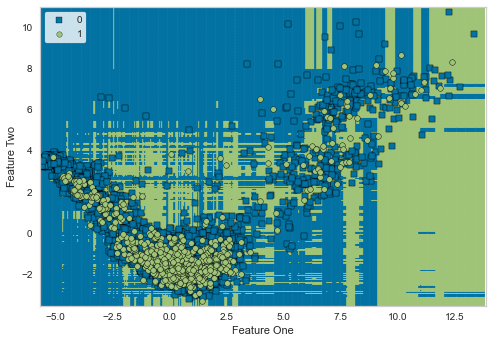

In [16]:
classification.plot_model(pycaret_model, plot = 'boundary', )

In [ ]:
from pycaret.classification import  *

top5 = compare_models(n_select = 5)

# tune top 5 base models
tuned_top5 = [tune_model(i) for i in top5]

# ensemble top 5 tuned models
bagged_top5 = [ensemble_model(i) for i in tuned_top5]

# blend top 5 base models 
blender = blend_models(estimator_list = top5) 

# select best model 
pycaret_automl = automl(optimize = 'Prec.')

In [32]:
predicted = classification.predict_model(bagged_pycaret_model, data = val_wo_dummy)
report(val_wo_dummy['Best Performance'], predicted['Label'], 'PyCaret', '')

The ROC AUC Score for PyCaret is: 0.56

Confusion Matrix: 
         Predict 0  Predict 1
Class 0       1129       1463
Class 1        128        271

Metrics Reports
              precision    recall  f1-score   support

           0       0.90      0.44      0.59      2592
           1       0.16      0.68      0.25       399

    accuracy                           0.47      2991
   macro avg       0.53      0.56      0.42      2991
weighted avg       0.80      0.47      0.54      2991




# Pycaret Bagged XGBOOST not Tuned model perform 0.54776 (highest)

In [ ]:
# classification.save_config('./xgboost_feature_selection_and_undersampling_config')

In [ ]:
# # Preprocess fix imbalanced data set with undersampling and feature selection set to true
# bagged_pycaret_model
# classification.save_model(bagged_pycaret_model, './xgboost_bagged_untuned_preprocess(featureselectioin and undersampling)')

### Ensemble Method

In [ ]:
# score_xgb = fit_xgb.score(X_test, y_test)

# score_rf = fit_rf.score(X_test, y_test)

# # score_mlp = fit_mlp.score(X_test, y_test)

# ensemble = VotingClassifier(estimators=[('XGB', fit_xgb), ('RF', fit_rf)],
#                         voting='soft',
#                         weights=[1, 1.3])

# ensemble = ensemble.fit(X_train,y_train)

In [ ]:
# y_pred_ensemble = ensemble.predict(X_test)
# report(y_test, y_pred_ensemble ,'Ensemble', fit_rf)

# Making Prediction

In [31]:
final_df = pd.read_csv('./test.csv')

fix_year(final_df)
fix_gpa(final_df)
final_df = clean_achievement_target(final_df)

In [32]:
final_df = transform_data(final_df)

In [35]:
set(final_df.columns) - set(X_train.columns)

{'job_level_JG03',
 'job_level_JG04',
 'job_level_JG05',
 'person_level_PG01',
 'person_level_PG02',
 'person_level_PG03',
 'person_level_PG04',
 'person_level_PG05',
 'person_level_PG06',
 'person_level_PG07'}

In [33]:
X_train.drop(list(num_feat_final), axis = 1, errors='ignore').drop('Best Performance', axis = 1).columns

NameError: name 'num_feat_final' is not defined

In [36]:
dif_col = list(set(X_train.columns) - set(final_df.columns))
final_df[dif_col] = 0
to_pred = final_df[X_train.columns]

# Making Predictions
predictions = fit_xgb.predict_proba(to_pred)
ans = pd.DataFrame(data = [x[1] for x in predictions], columns = ['Best Performance']).reset_index().set_index('index')
ans.to_csv('./answer.csv')

In [37]:
pd.read_csv('./answer.csv')

,index,Best Performance
0,0,0.498543
1,1,0.499979
2,2,0.500439
3,3,0.500055
4,4,0.499226
...,...,...
5995,5995,0.499789
5996,5996,0.500424
5997,5997,0.499710
5998,5998,0.502031


## PyCaret Path

Pycaret model gradient boosting classifier with undersampling tuned scored 54% !

In [ ]:
# Counting Result
classification.predict_model(bagged_pycaret_model, final_df)['Label'].value_counts()

In [ ]:
# PyCaret Path Probabilities
final_df = classification.get_config('prep_pipe').transform(final_df)
ans_pyc = pd.DataFrame((x[1] for x in bagged_pycaret_model.predict_proba(final_df))).reset_index().rename(columns = {0: 'Best Performance'}).set_index('index')
ans_pyc.to_csv('./answer.csv')

In [ ]:
pd.read_csv('./answer.csv')